In [1]:
from train_pointnet import LitModel1
from dataset.shapenet import ShapeNetPart
from torch.utils.data import DataLoader
from einops import rearrange
import torch

%matplotlib ipympl

In [17]:
net = LitModel1.load_from_checkpoint("wandb/hyperbolic/7no28jy7/checkpoints/last.ckpt").to(torch.device("cpu"))

In [18]:
mlr = net.net.mlr

In [19]:
pts = mlr.points.detach()
pts.shape

torch.Size([66, 3])

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection

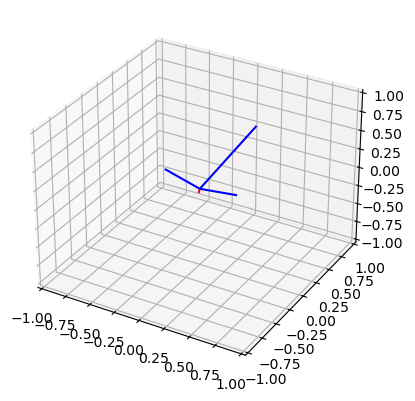

In [21]:
def plt_gyroplanes(ax, pts, dirs, c, color="blue"):   
    # sampling dir
    N = 1000
    B = pts.shape[0]
    vecs = torch.randn((N,2))
    # shift them around dirs
    vec1 = torch.stack([-dirs[:,1], dirs[:,0], torch.zeros((B,))],dim=-1) # B,3
    vec2 = torch.stack([-dirs[:,2], torch.zeros((B,)), dirs[:,0]],dim=-1) # B,3
    vecs = vec1[None,:,:]*vecs[:,None,:1] + vec2[None,:,:]*vecs[:,None,1:] # N,B,3
    
    inhyp = mlr.ball.expmap(pts, vecs)
    r = c.pow(-1).sqrt()
    
    origins = torch.zeros_like(pts)

    lines = torch.stack([origins, pts], dim=-2)

    coll = Line3DCollection(lines, colors=color)
    ax.add_collection(coll)
    
    for i in range(B):
        print(i)
        print(pts[i])
        print(dirs[i])
        ax.scatter(inhyp[:,i,0], inhyp[:,i,1], inhyp[:,i,2], s=2)
    
    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    ax.set_zlim(-r, r)
    

def plt_points(ax, pts, c, color="blue"):
    origins = torch.zeros_like(pts)

    lines = torch.stack([origins, pts], dim=-2)

    coll = Line3DCollection(lines, colors=color)

    r = c.pow(-1).sqrt() # c|x|² < 1 => |x| < sqrt(1/c)

    #ax.scatter(pts[:,0,:], pts[:,1], pts[:,2])
    ax.add_collection(coll)

    ax.set_xlim(-r, r)
    ax.set_ylim(-r, r)
    ax.set_zlim(-r, r)

def plt_scatter_sphere(ax, r): 
    pass
    
ax = plt.figure().add_subplot(projection='3d')  

CLS = 15

ps_i = [16 + p for p in ShapeNetPart.cls2parts[CLS]]
plt_points(ax, pts[[CLS]], mlr.ball.c, color="red")
plt_points(ax, pts[ps_i], mlr.ball.c)
plt.show()

0
tensor([-0.1293, -0.1565, -0.0542])
tensor([-1.2199, -2.1791, -1.4078])


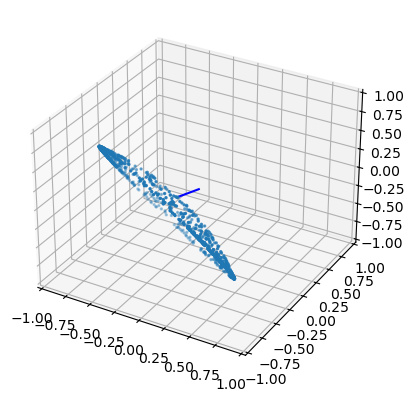

In [22]:
plt_gyroplanes(plt.figure().add_subplot(projection='3d'), pts[4:5].detach(), mlr.dirs[4:5].detach(), mlr.ball.c)

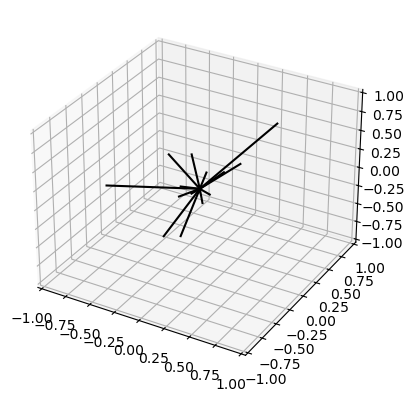

In [23]:
plt_points(plt.figure().add_subplot(projection='3d'), pts[:16], mlr.ball.c, color="black")

Text(0, 0.5, '$||point_{class}||^2$')

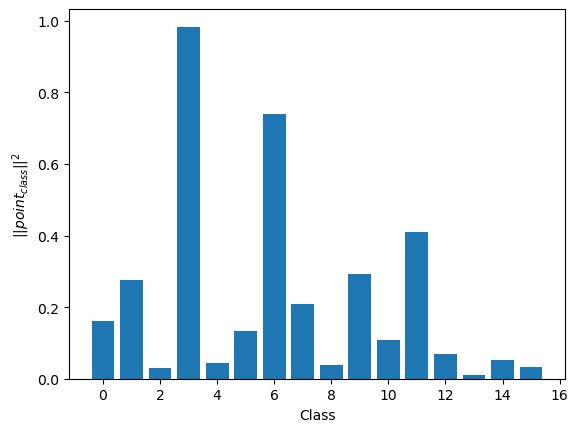

In [24]:
plt.bar(torch.arange(16), pts[:16].pow(2).sum(dim=-1))
plt.xlabel("Class")
plt.ylabel("$||point_{class}||^2$")

In [25]:
H = net.hparams
val_data = DataLoader(ShapeNetPart(n_points=H.n_points, partition='test'), batch_size=H.batch_size, num_workers=4, shuffle=False, pin_memory=True)
val_data_iter = iter(val_data)
x,cls,y = next(val_data_iter)
x = rearrange(x, 'b n d -> b d n')

In [26]:
mlr_inputs = net.net.net(x).detach()
mlr_inputs = mlr_inputs.permute(0,2,1)
logits = net(x).detach()
adj_logits = net.adjust_logits2(logits)

In [27]:
import matplotlib.colors as mcolors
COLORS = list(mcolors.TABLEAU_COLORS.values())

In [28]:
def show(i):
    print("CLASS", cls[i].item())
    
    CLS = cls[i]
    
    mesh2hyp = mlr.ball.expmap0(mlr_inputs[i]).detach()
    
    parts = ShapeNetPart.cls2parts[CLS]
    parts_to_color = { p : COLORS[i_] for i_,p in enumerate(parts) }
    
    ax = plt.figure().add_subplot(projection='3d')
    ax.scatter(mesh2hyp[:,0], mesh2hyp[:,1], mesh2hyp[:,2], c=[parts_to_color[el.item()] for el in y[i]], s=1)
    
    ps_i = [16 + p for p in parts]
    plt_points(ax, pts[[CLS]], mlr.ball.c, color="black")
    plt_points(ax, pts[ps_i], mlr.ball.c, color=[parts_to_color[el] for el in parts])
    #plt_gyroplanes(ax, pts[ps_i], mlr.dirs[ps_i].detach(), mlr.ball.c, color=[parts_to_color[el] for el in parts])
    plt.show()

CLASS 4


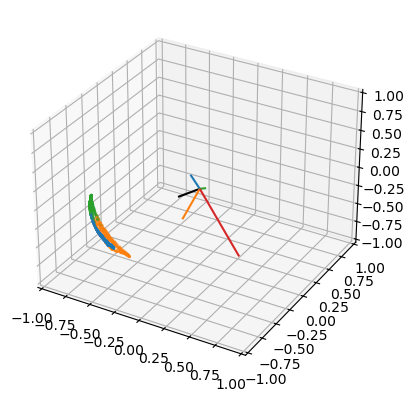

In [29]:
show(3)

In [30]:
part2cls = {}
for c in range(16):
    for p in ShapeNetPart.cls2parts[c]:
        part2cls[p] = c
#part2cls

In [31]:
classesinbatch = set(cls.flatten().tolist())
classesinbatch

{0, 4, 8, 12, 15}

i = 2
CLASS 0


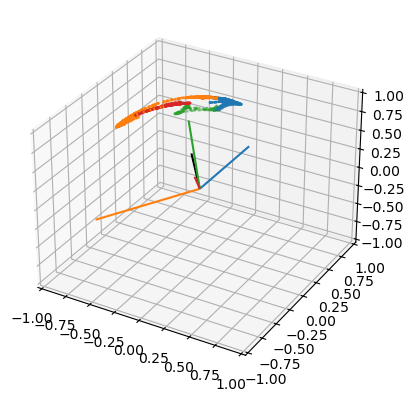

i = 6
CLASS 0


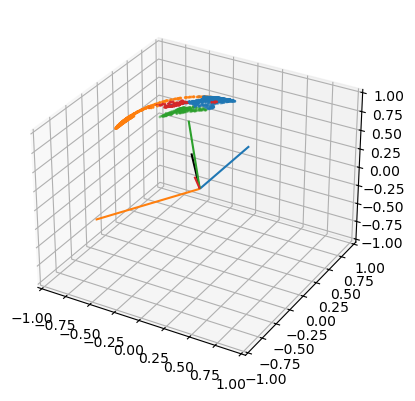

i = 10
CLASS 0


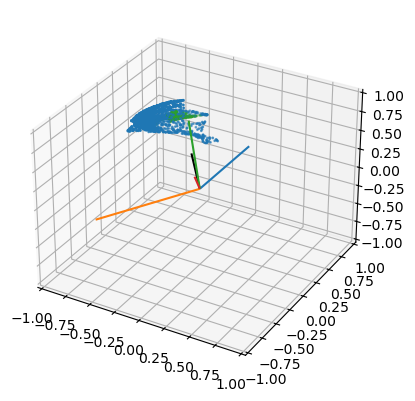

i = 0
CLASS 4


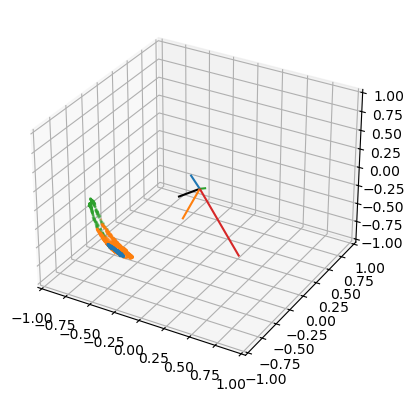

i = 3
CLASS 4


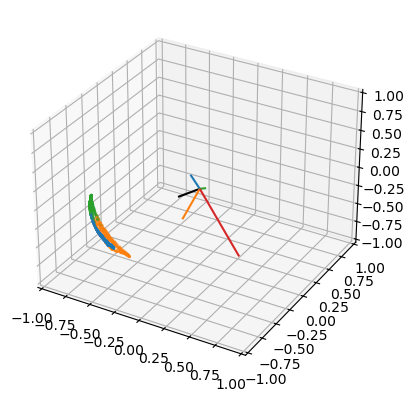

i = 4
CLASS 4


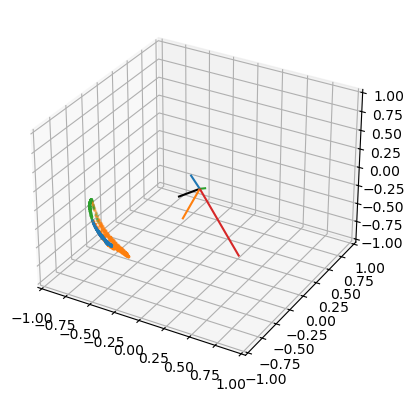

i = 5
CLASS 4


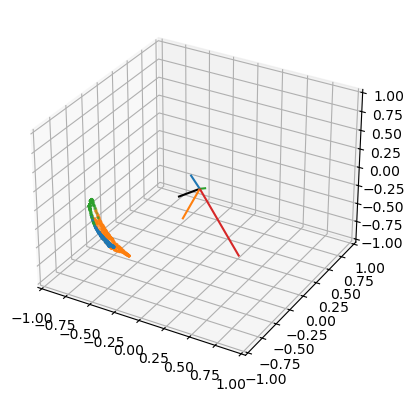

i = 7
CLASS 4


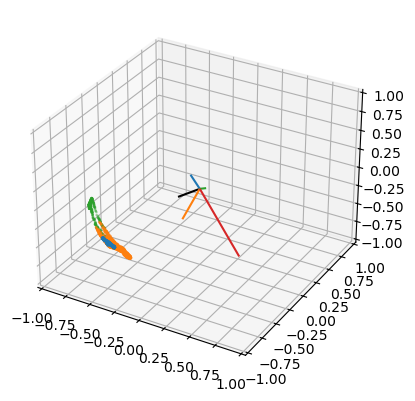

i = 13
CLASS 4


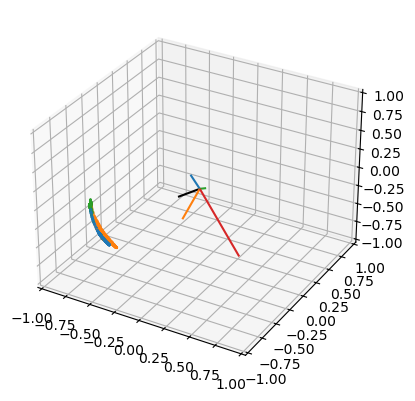

i = 9
CLASS 8


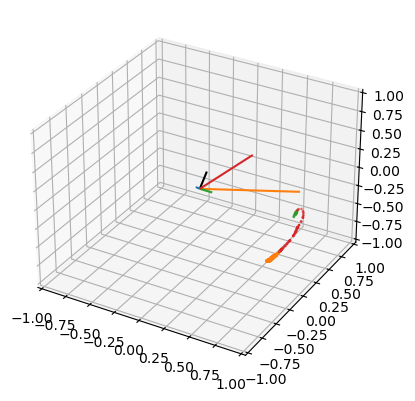

i = 15
CLASS 12


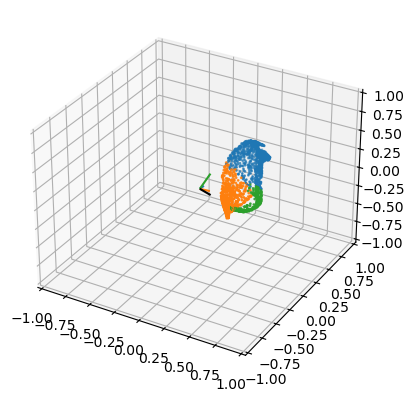

i = 1
CLASS 15


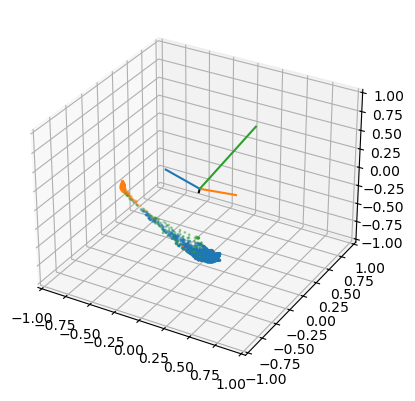

i = 8
CLASS 15


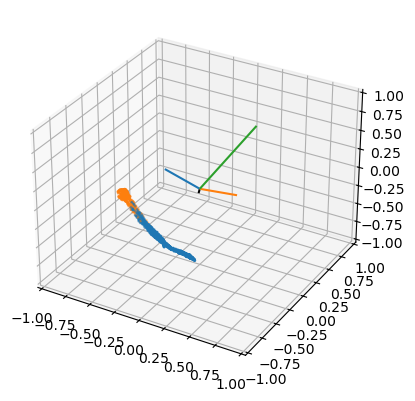

i = 11
CLASS 15


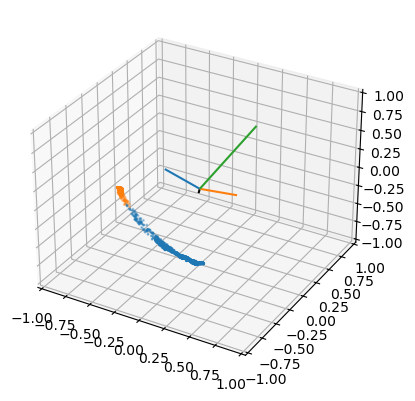

i = 12
CLASS 15


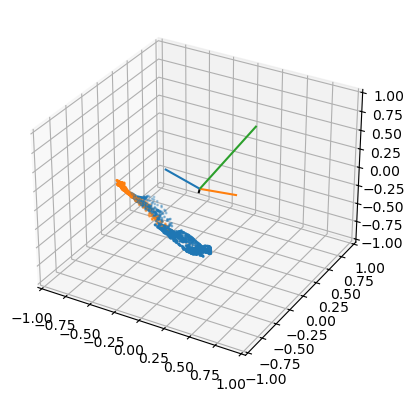

i = 14
CLASS 15


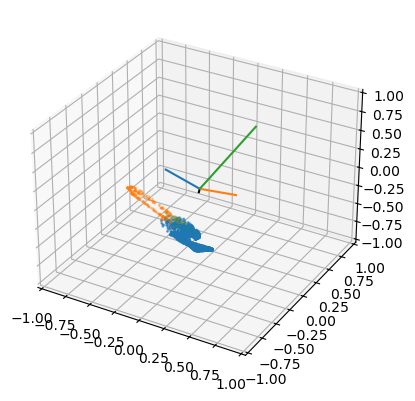

In [32]:
for c in classesinbatch:
    indices = cls == c
    rg = torch.arange(len(indices))[:,None]
    for i in rg[indices]:
        print("i =", i.item())
        show(i)

=> classes seem to be consistently distributed

In [33]:
ShapeNetPart.cls2parts[15]

[47, 48, 49]

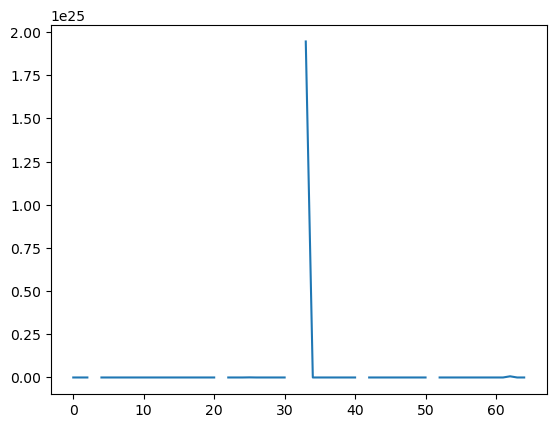

In [37]:
plt.plot(logits[14,:,0].clamp(min=1e-15).exp())